# ノート 8 補足 複数のモデルを使った複数特徴量での ML


In [1]:
from pprint import pprint

import matplotlib.pyplot as plt
import numpy as np

import warnings

warnings.filterwarnings("ignore")


%config InlineBackend.figure_format = 'retina'

### 複数の特徴量を入力とした分類問題

データを読み込みます。`features_to_keep` を変更してすべての特徴量を読み込みます。


In [2]:
import sys

sys.path.insert(1, "../scripts/")
from aux_functions import load_n_combine_df

(X_train, y_train), (X_validate, y_validate), (X_test, y_test) = load_n_combine_df(
    path_to_data="../datasets/sevir/",
    features_to_keep=np.arange(0, 36, 1),  # 36個のすべての特徴量
    class_labels=True,  # ラベルをクラス化
)

ノート 6、7 で学んだように複数の特徴量を入力とする場合は規格化が必要です。


In [3]:
from sklearn.preprocessing import StandardScaler

# Scalarクラスを訓練データに適合させる
scaler = StandardScaler()
scaler.fit(X_train)

# transform メソッドで特徴量をスケール
X_train = scaler.transform(X_train)
X_validate = scaler.transform(X_validate)
X_test = scaler.transform(X_test)

# 平均と標準偏差を確認
np.mean(X_train, axis=0), np.std(X_train, axis=0)

(array([ 4.56472368e-16,  3.53052847e-16,  2.49633326e-17,  6.47008825e-17,
         2.03782307e-18,  6.24083316e-17,  2.36132748e-16, -2.13971423e-16,
        -1.21250473e-16, -7.13238075e-17,  3.44901555e-16,  2.64916999e-16,
         8.86962492e-16, -2.30834408e-15, -4.03361604e-16,  3.12551114e-16,
         4.87803898e-16, -1.91810097e-16, -3.89733663e-17, -2.39444211e-16,
         2.79181761e-16,  1.12080269e-17,  1.46977989e-16,  6.58471580e-17,
        -1.54492462e-16,  1.64936305e-16, -8.58432969e-17, -8.66074806e-18,
        -1.29911221e-17,  2.98031624e-17, -1.96140471e-17, -3.13315297e-17,
        -4.83982980e-18,  7.20243092e-17,  2.62369721e-17,  1.23288296e-16]),
 array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1.]))

In [4]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import GaussianNB

model_list = [
    LogisticRegression(),  # ロジスティック回帰
    GaussianNB(),  # 確率分布がガウス分布のナイーブベイズ
    DecisionTreeClassifier(),  # 決定木
    RandomForestClassifier(),  # ランダムフォレスト
    GradientBoostingClassifier(),  # 勾配ブースト決定木
    LinearSVC(dual=False),  # サポートベクトルマシン（線形カーネル、双体問題を解かない）
]

pprint(model_list)

[LogisticRegression(),
 GaussianNB(),
 DecisionTreeClassifier(),
 RandomForestClassifier(),
 GradientBoostingClassifier(),
 LinearSVC(dual=False)]


学習を行います。特徴量が多いので学習には時間がかかります（PC の環境に依存しますが 10 分程度かかりました）。
時間がない場合や PC の処理能力が低い場合は、学習と保存を行う次の 2 つのセルのコードをスキップして学習済みモデルをロードしてください。


In [5]:
import tqdm  # ループの進行具合を表示するため

for model in tqdm.tqdm(model_list):
    model.fit(X_train, y_train)

100%|██████████| 6/6 [07:01<00:00, 70.31s/it] 


学習済みモデルを永続化しておきましょう。特に決定木モデルのファイルサイズが大きくなるのでレポジトリ登録のために圧縮しています。


In [6]:
import pickle
from pathlib import Path
import bz2

save_dir = Path("../datasets/sklearnmodels/classification/allfeatures")
save_files = [
    save_dir / "LogisticRegression.pkl",
    save_dir / "NaiveBayes.pkl",
    save_dir / "DecisionTree.pkl.bz2",
    save_dir / "RandomForest.pkl.bz2",
    save_dir / "GradientBoostedTrees.pkl.bz2",
    save_dir / "SupportVectorMachines.pkl",
]
if not save_dir.exists():
    save_dir.mkdir(parents=True)
for model, save_file in zip(model_list, save_files):
    if save_file.suffix == ".bz2":
        with bz2.open(save_file, "wb") as f:
            pickle.dump(model, f, protocol=pickle.HIGHEST_PROTOCOL)
    else:
        with open(save_file, "wb") as f:
            pickle.dump(model, f, protocol=pickle.HIGHEST_PROTOCOL)

学習をスキップした場合は次のセルを実行して永続化したモデルを読み込んでください。


In [8]:
import pickle
from pathlib import Path
import bz2

save_dir = Path("../datasets/sklearnmodels/classification/allfeatures")
save_files = [
    save_dir / "LogisticRegression.pkl",
    save_dir / "NaiveBayes.pkl",
    save_dir / "DecisionTree.pkl.bz2",
    save_dir / "RandomForest.pkl.bz2",
    save_dir / "GradientBoostedTrees.pkl.bz2",
    save_dir / "SupportVectorMachines.pkl",
]
model_list = []
for save_file in save_files:
    if save_file.suffix == ".bz2":
        with bz2.open(save_file, "rb") as f:
            model = pickle.load(f)
    else:
        with open(save_file, "rb") as f:
            model = pickle.load(f)
    model_list.append(model)

パフォーマンスダイアグラム、ROC 曲線を描画します。


In [9]:
# ユーティリティ関数の読み込み
from gewitter_functions import (
    get_contingency_table,
    make_performance_diagram_axis,
    get_acc,
    get_pod,
    get_sr,
)


def plot_performance_diagram_classification(model_list):
    # パフォーマンスダイアグラムのAxesオブジェクト
    ax = make_performance_diagram_axis()

    # 色とラベルのリスト
    colors = ["b", "r", "g", "y", "LightGreen", "k"]
    legend_labels = ["LgR", "NB", "DT", "RF", "GBT", "SVM"]

    for idx, model in enumerate(model_list):
        # 検証データからの予測
        yhat = model.predict(X_validate)
        # 分割表を計算
        cont_table = get_contingency_table(yhat, y_validate)

        # 指標を求める
        accuracy = get_acc(cont_table)
        pod = get_pod(cont_table)
        sr = get_sr(cont_table)

        ax.plot(sr, pod, "o", c=colors[idx], mfc="w", label=legend_labels[idx])
        print("{} accuracy: {}%".format(legend_labels[idx], np.round(accuracy, 0)))

    ax.legend()

LgR accuracy: 90.0%
NB accuracy: 84.0%
DT accuracy: 86.0%
RF accuracy: 90.0%
GBT accuracy: 90.0%
SVM accuracy: 90.0%


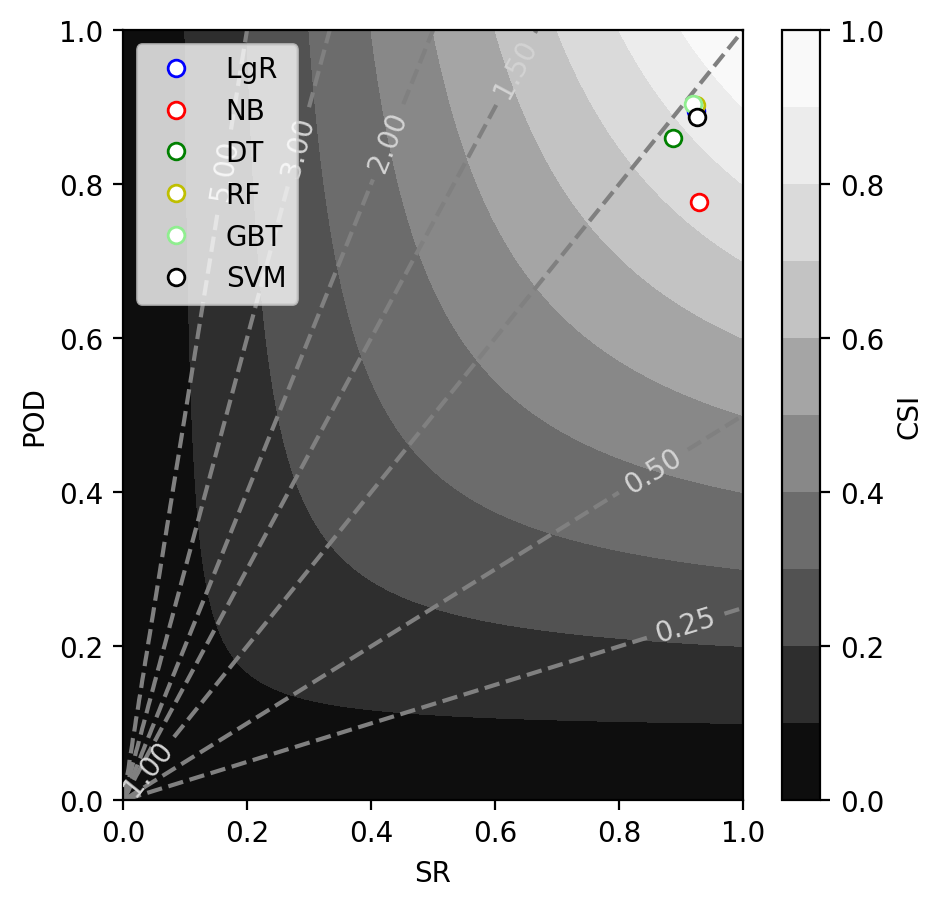

In [10]:
plot_performance_diagram_classification(model_list)

In [11]:
# ユーティリティ関数
from gewitter_functions import get_points_in_roc_curve, get_area_under_roc_curve


def plot_roc_classification(model_list):
    fig, ax = plt.subplots(figsize=(4.1, 5))

    # プロットの色とラベル
    colors = ["b", "r", "g", "y", "LightGreen", "k"]
    legend_labels = ["LgR", "NB", "DT", "RF", "GBT", "SVM"]

    for idx, model in enumerate(model_list[:-1]):
        # 検証データからの予測される分類確率
        yhat_proba = model.predict_proba(X_validate)

        # クラス1の予測でプロット（2分類問題なのでクラス0とクラス1の確率の和は1）
        y_preds = yhat_proba[:, 1]

        # ROC曲線の計算
        pofds, pods = get_points_in_roc_curve(
            forecast_probabilities=y_preds,
            observed_labels=y_validate,
            threshold_arg=np.linspace(0, 1, 100),
        )
        # AUCの計算
        auc = get_area_under_roc_curve(pofds, pods)

        ax.plot(
            pofds,
            pods,
            "-",
            color=colors[idx],
            label=f"{legend_labels[idx]}: {np.round(auc, 2)}",
        )

        print("{} AUC: {}".format(legend_labels[idx], np.round(auc, 2)))

    ax.legend(loc="lower right")

    ax.set_xlim([0, 1])
    ax.set_ylim([0, 1])

    ax.plot([0, 1], [0, 1], "--", color="Grey")

    ax.set_title("AUC of ROC Curve")
    ax.set_xlabel("POFD")
    ax.set_ylabel("POD")

    fig.tight_layout()

LgR AUC: 0.97
NB AUC: 0.9
DT AUC: 0.86
RF AUC: 0.97
GBT AUC: 0.97


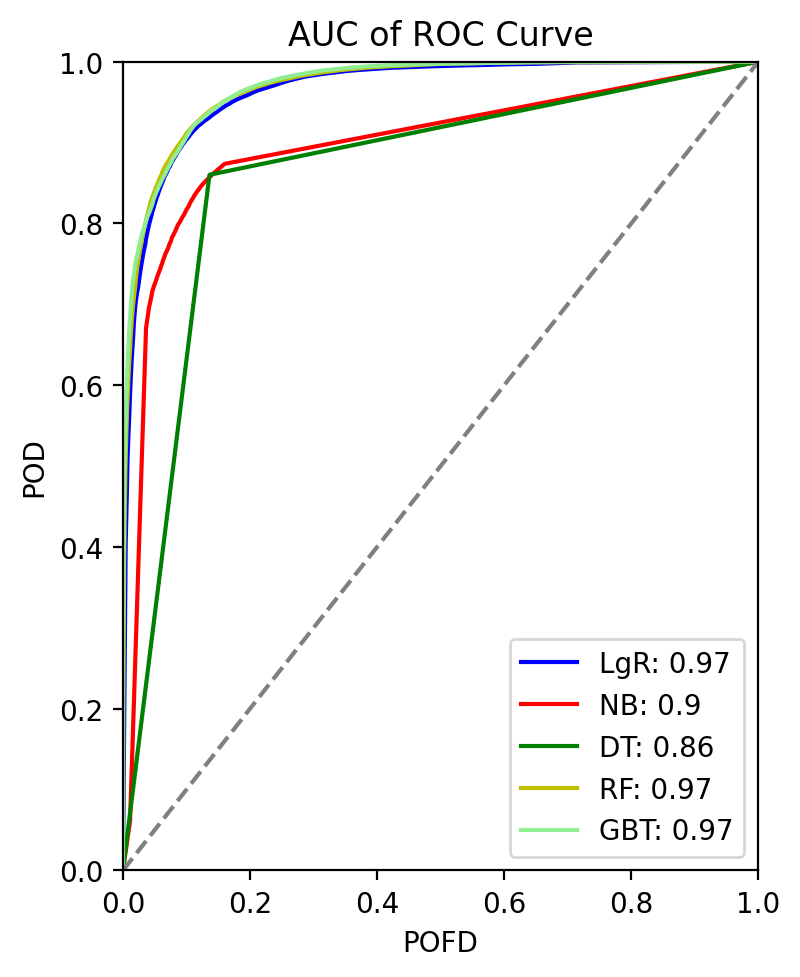

In [12]:
plot_roc_classification(model_list)

### 複数の特徴量を入力とした回帰問題

データを読み込みます。`features_to_keep` を変更してすべての特徴量を読み込みます。

#### 注意

学習済みモデルのサイズが非常に多くなったためレポジトリには学習済みモデルは登録していません。
このため、必ず 1 度は計算を行う必要があります。


In [25]:
import matplotlib.pyplot as plt
import numpy as np

%config InlineBackend.figure_format = 'retina'

import sys

sys.path.insert(1, "../scripts/")
from aux_functions import load_n_combine_df

(X_train, y_train), (X_validate, y_validate), (X_test, y_test) = load_n_combine_df(
    path_to_data="../datasets/sevir/",
    features_to_keep=np.arange(0, 36, 1),  # 36個のすべての特徴量
    class_labels=False,  # ラベルを二値にしない
    dropzeros=True,  # 発雷数ぜロのデータを削除
)

In [26]:
from sklearn.preprocessing import StandardScaler

# Scalarクラスを訓練データに適合させる
scaler = StandardScaler()
scaler.fit(X_train)

# transform メソッドで特徴量をスケール
X_train = scaler.transform(X_train)
X_validate = scaler.transform(X_validate)
X_test = scaler.transform(X_test)

# 平均と標準偏差を確認
np.mean(X_train, axis=0), np.std(X_train, axis=0)

(array([ 7.74633690e-16, -1.56667488e-16, -2.87735713e-16, -2.57528583e-16,
         2.30393364e-17,  2.35513217e-17, -6.94380001e-17, -7.21899209e-17,
         1.77530887e-16,  2.40223481e-15, -6.88108182e-16, -4.63858640e-16,
        -6.53293185e-16,  3.88852801e-16, -4.31987558e-16, -2.67256303e-16,
         1.10550416e-15, -2.05306087e-16,  1.10076830e-17,  2.81591890e-18,
        -3.83988941e-17, -1.47195761e-16, -1.43355871e-17, -4.91505844e-17,
        -3.99348498e-17,  9.62532278e-17,  1.97370316e-16, -2.45752922e-17,
        -2.96951448e-17,  1.04956977e-17, -3.96788572e-18,  4.09588204e-18,
        -3.59029660e-17, -3.83988941e-19,  3.21270747e-17,  3.47637988e-16]),
 array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1.]))

In [27]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import LinearSVR

# initialize
model_list = [
    LinearRegression(),  # 線形回帰
    DecisionTreeRegressor(),  # 決定木
    RandomForestRegressor(),  # ランダムフォレスト
    GradientBoostingRegressor(),  # 勾配ブースト決定木
    LinearSVR(),  # 線形SVM
]

pprint(model_list)

[LinearRegression(),
 DecisionTreeRegressor(),
 RandomForestRegressor(),
 GradientBoostingRegressor(),
 LinearSVR()]


学習を行います。特徴量が多いので学習には時間がかかります（PC の環境に依存しますが 15 分程度かかりました）。
既に以下のセルを実行済みで永続化データが保存されている場合はスキップして読み込みを行うセルのみ実行してください。


In [28]:
import tqdm  # ループの進行具合を表示するため

for model in tqdm.tqdm(model_list):
    model.fit(X_train, y_train)

100%|██████████| 5/5 [12:09<00:00, 145.94s/it]


次回以降に再学習しなくてよいように学習済みモデルを永続化しておきましょう。特に決定木モデルのファイルサイズが大きくなるので圧縮しています。


In [29]:
import pickle
from pathlib import Path
import bz2

save_dir = Path("../datasets/sklearnmodels/regression/allfeatures")
save_files = [
    save_dir / "LogisticRegression.pkl",
    save_dir / "DecisionTree.pkl.bz2",
    save_dir / "RandomForest.pkl.bz2",
    save_dir / "GradientBoostedTrees.pkl.bz2",
    save_dir / "SupportVectorMachines.pkl",
]
if not save_dir.exists():
    save_dir.mkdir(parents=True)
for model, save_file in zip(model_list, save_files):
    if save_file.suffix == ".bz2":
        with bz2.open(save_file, "wb") as f:
            pickle.dump(model, f, protocol=pickle.HIGHEST_PROTOCOL)
    else:
        with open(save_file, "wb") as f:
            pickle.dump(model, f, protocol=pickle.HIGHEST_PROTOCOL)

学習をスキップした場合は次のセルを実行して永続化したモデルを読み込んでください。


In [30]:
import pickle
from pathlib import Path
import bz2

save_dir = Path("../datasets/sklearnmodels/regression/allfeatures")
save_files = [
    save_dir / "LogisticRegression.pkl",
    save_dir / "DecisionTree.pkl.bz2",
    save_dir / "RandomForest.pkl.bz2",
    save_dir / "GradientBoostedTrees.pkl.bz2",
    save_dir / "SupportVectorMachines.pkl",
]
model_list = []
for save_file in save_files:
    if save_file.suffix == ".bz2":
        with bz2.open(save_file, "rb") as f:
            model = pickle.load(f)
    else:
        with open(save_file, "rb") as f:
            model = pickle.load(f)
    model_list.append(model)

散布図を作成します。


In [31]:
# ユーティリティ関数
from aux_functions import boxbin, make_colorbar


def plot_scatter_regression(model_list):
    fig, axes = plt.subplots(2, 3, figsize=(7.5, 5))

    # 散布図の密度は33分割して計算
    n = 33
    xbins = np.logspace(0, 3.5, n)
    ybins = np.logspace(0, 3.5, n)

    # 色とラベル
    labels = ["LnR", "DT", "RF", "GBT", "SVM"]
    colors = ["r", "b", "orange", "purple", "dimgrey"]
    cmaps = ["Reds_r", "Blues_r", "Oranges_r", "Purples_r", "Greys_r"]

    # Axesのリストをループしやすいように変形
    axes = axes.ravel()

    # draw a new axis for a new colorbar to go on
    ax_cbar = fig.add_axes([0.75, 0.15, 0.015, 0.33])
    # draw that colorbar
    cbar = make_colorbar(ax_cbar, 0, 2, plt.cm.Greys_r)
    # label that colorbar
    cbar.set_label("$\%$ of total points")

    for i, ax in enumerate(axes[:5]):
        # ログスケールにする
        ax.semilogy()
        ax.semilogx()

        # 検証データから予測
        model = model_list[i]
        yhat = model.predict(X_validate)

        # 散布図
        ax.scatter(yhat, y_validate, color=colors[i], s=1, marker="+")

        # 密度をプロット
        ax, cbar, _ = boxbin(
            yhat,
            y_validate,
            xbins,
            ybins,
            ax=ax,
            mincnt=100,
            normed=True,
            cmap=cmaps[i],
            vmin=0,
            vmax=2,
            cbar=False,
        )

        # 軸とメモリの設定
        ax.set_xlim([1, 4000])
        ax.set_xticks([1, 10, 100, 1000])
        ax.set_yticks([1, 10, 100, 1000])
        ax.set_ylim([1, 4000])

        # 対角線
        ax.plot([1, 4000], [1, 4000], "--k", alpha=0.5)

        ax.set_title(labels[i])

    axes[5].axis("off")  # 6番目のAxesは描画しない
    axes[0].set_ylabel(r"$y$, [# of flashes]")
    axes[3].set_ylabel(r"$y$, [# of flashes]")
    axes[4].set_xlabel(r"$\hat{y}$, [# of flashes]")

    fig.tight_layout()

n_samples= 26367.0
n_samples= 26935.0
n_samples= 35659.0
n_samples= 34884.0
n_samples= 29160.0


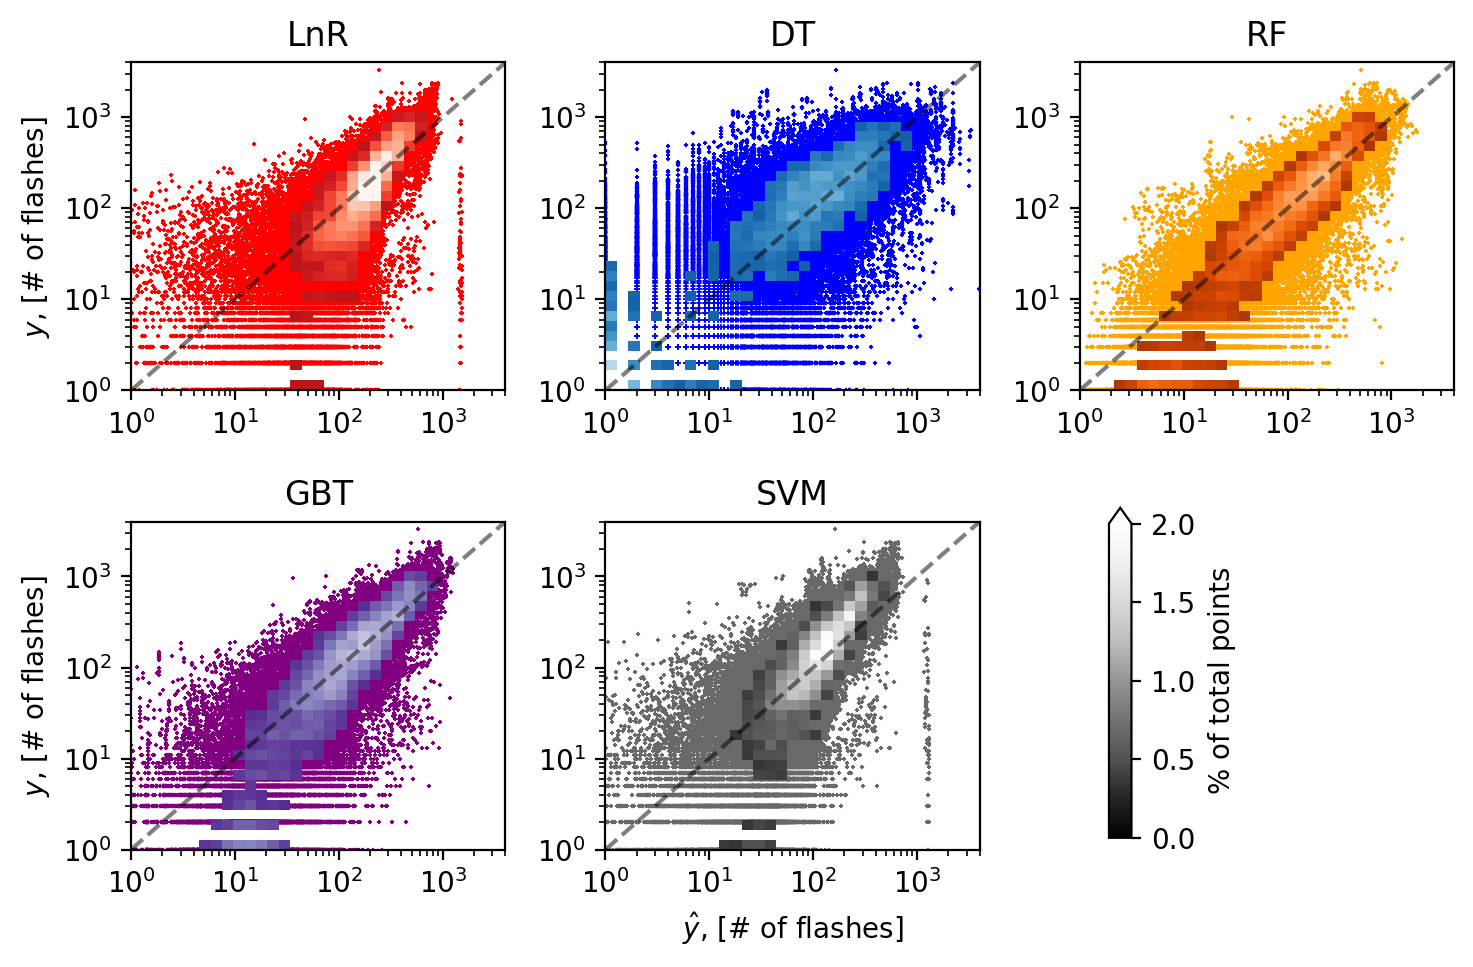

In [32]:
plot_scatter_regression(model_list)

指標を計算して比較します。


In [33]:
# ユーティリティ関数
from gewitter_functions import get_mae, get_rmse, get_bias, get_r2


def plot_metrics_regression(model_list):
    fig, axes = plt.subplots(2, 2, figsize=(5, 5))

    labels = ["LnR", "DT", "RF", "GBT", "SVM"]
    colors = ["r", "b", "orange", "purple", "dimgrey"]
    labels = ["LnR", "DT", "RF", "GBT", "SVM"]

    for i, model in enumerate(model_list):
        # 検証データからの予測
        yhat = model.predict(X_validate)
        # 指標
        mae = get_mae(y_validate, yhat)
        rmse = get_rmse(y_validate, yhat)
        bias = get_bias(y_validate, yhat)
        r2 = get_r2(y_validate, yhat)

        ############### subplot 0,0: Bias ########################
        ax = axes[0, 0]
        # 棒グラフの位置をモデル毎にずらす
        ax.bar(i, bias, width=0.95, color=colors[i])
        # 値をテキストでプロット
        annotate = str(int(np.round(bias))).rjust(3, " ")
        ax.text(i - 0.4, bias + 5, annotate)

        ####### subplot 0,1: Mean Absolute Error #################
        ax = axes[0, 1]
        ax.bar(i, mae, width=0.95, color=colors[i])
        annotate = str(int(np.round(mae))).rjust(3, " ")
        ax.text(i - 0.4, mae + 5, annotate)

        ####### subplot 1,0: Root Mean Squared Error #############
        ax = axes[1, 0]
        ax.bar(i, rmse, width=0.95, color=colors[i])
        annotate = str(int(np.round(rmse))).rjust(3, " ")
        ax.text(i - 0.4, rmse + 5, annotate)

        ####### subplot 1,1: Rsquared ###########################
        ax = axes[1, 1]
        ax.bar(i, r2, width=0.95, color=colors[i])
        annotate = str(np.round(r2, 2)).ljust(4, "0")
        ax.text(i - 0.5, r2 + 0.05, annotate)

    ax = axes[0, 0]
    ax.xaxis.set_ticks(np.arange(0, 5))
    ax.xaxis.set_ticklabels(labels, rotation=45)
    ax.set_ylim([-130, 130])
    ax.set_title("Bias")

    ax = axes[0, 1]
    ax.set_ylim([0, 200])
    ax.xaxis.set_ticks(np.arange(0, 5))
    ax.xaxis.set_ticklabels(labels, rotation=45)
    ax.set_title("Mean Abs. Error")

    ax = axes[1, 0]
    ax.set_ylim([0, 300])
    ax.xaxis.set_ticks(np.arange(0, 5))
    ax.xaxis.set_ticklabels(labels, rotation=45)
    ax.set_title("Root Mean Sq. Error")

    ax = axes[1, 1]
    ax.set_ylim([-1, 1])
    ax.xaxis.set_ticks(np.arange(0, 5))
    ax.xaxis.set_ticklabels(labels, rotation=45)
    ax.set_title("$R^{2}$")

    fig.tight_layout()

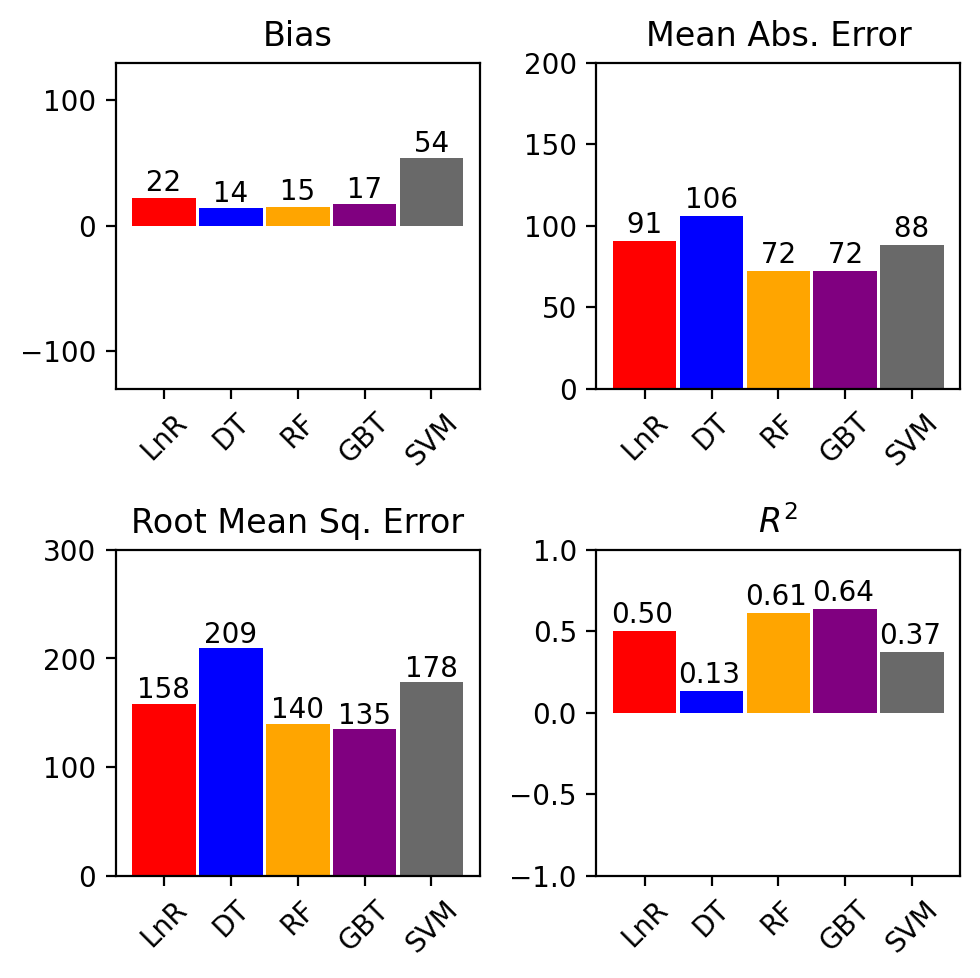

In [34]:
plot_metrics_regression(model_list)